In [1]:
import os

import uproot
import awkward as ak
import dask
import numpy as np
import hist

import warnings
warnings.filterwarnings("ignore")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema

In [2]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights",
        ]

In [3]:
%%time

# mc_file = "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000012.pool.root.1"
mc_file = "DAOD_PHYSLITE.37620644._000012.pool.root.1"

access_log = []
events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    mode="virtual",
    # uproot_options=dict(filter_name=filter_name),
    access_log=access_log
).events()
access_log

CPU times: user 603 ms, sys: 12.9 ms, total: 616 ms
Wall time: 616 ms


[]

In [4]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    DDL1 = np.log(DDL1)

    return DDL1

In [5]:
B_TAG_THRESHOLD = 2.456

def calculate_preselections(events):
    # pT > 30 GeV and abs(etha)<2.1 for leptons
    selected_electrons = events.Electrons[events.Electrons.pt > 30000 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30000 & (np.abs(events.Muons.eta) < 2.1)]
    
    # calculate tagging variable and manually attach it to jets (which passed the preselection)
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    
    # pT > 25 GeV and abs(etha) < 2.4 for jets
    selected_jets = jets[events.Jets.pt > 25000 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    
    return event_filters, selected_jets
    
def calculate_trijet_mass_and_ev_filter(event_filters, selected_jets):    
        
    # at least two b-tagged jets ("tag" means score above threshold)
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass), event_filters


def calculate_Ht_and_ev_filter(event_filters, selected_jets):
    
    # exactly ont b-tagged jets ("tag" means score above threshold)
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) == 1)
    selected_jets = selected_jets[event_filters]
    
    observable_Ht = ak.sum(selected_jets.pt, axis=-1)
    
    return observable_Ht, event_filters

In [6]:
%%time

event_filters, selected_jets = calculate_preselections(events)

reconstructed_top_mass, _ = calculate_trijet_mass_and_ev_filter(event_filters, selected_jets)
hist_reco_mtop = hist.Hist.new.Reg(25, 50, 550, label="$m_{bjj} [GeV]$").Double().fill(reconstructed_top_mass/1000)

observable_Ht, _ = calculate_Ht_and_ev_filter(event_filters, selected_jets)
hist_Ht = hist.new.Reg(25, 70, 570, label="$H_T$ [GeV/c]").Double().fill(observable_Ht/1000)

access_log

CPU times: user 763 ms, sys: 239 ms, total: 1 s
Wall time: 956 ms


['AnalysisElectronsAuxDyn.trackParticleLinks',
 'AnalysisElectronsAuxDyn.eta',
 'AnalysisElectronsAuxDyn.pt',
 'AnalysisMuonsAuxDyn.pt',
 'AnalysisMuonsAuxDyn.eta',
 'AnalysisMuonsAuxDyn.pt',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb',
 'AnalysisJetsAuxDyn.pt',
 'AnalysisJetsAuxDyn.eta',
 'AnalysisJetsAuxDyn.pt',
 'AnalysisJetsAuxDyn.phi',
 'AnalysisJetsAuxDyn.m']

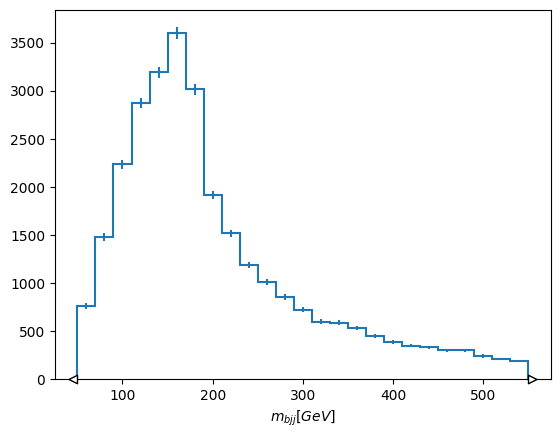

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.plot()

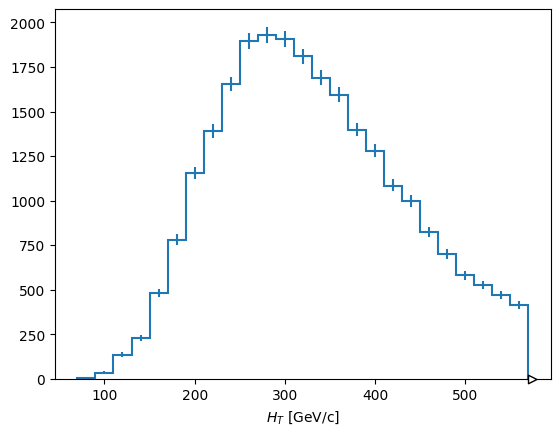

In [8]:
# perform computation and visualize
artists = hist_Ht.plot()

In [9]:
LUMINOSITY = 36640 

def create_histograms(events):
        
    # Fetching metadata
    cross_section = events.metadata["crossSection_pb"]
    filter_efficiency = events.metadata["genFiltEff"]
    k_factor = events.metadata["kFactor"]
    process_label = events.metadata["process-label"]
    variation = events.metadata["variation"]
    
    # Calculate the sum of weights for the currently processing PHYSELITE file.
    sum_of_mc_weights = ak.sum(events.EventInfo.mcEventWeights[:, 0])
    
    # calculate lumi_weight constant term
    lumi_weight = LUMINOSITY * cross_section * k_factor * filter_efficiency
            
    # Retrieve events and jet's preselection
    event_filters, selected_jets = calculate_preselections(events)
    
    ##############################################
    ## Trijet mass calculation
    ##############################################
    reconstructed_top_mass, event_filters_mass = calculate_trijet_mass_and_ev_filter(event_filters, selected_jets)    
    mc_weight_mass = events.EventInfo.mcEventWeights[:, 0][event_filters_mass]
    
    hist_reco_mtop = (hist.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .StrCat([], name="variation", label="Systematic variation", growth=True)
                     .Weight()
                     .fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight_mass, process=process_label, variation=variation) )
    
    ##############################################
    ## Ht calculation                             
    ##############################################
    observable_Ht, event_filters_Ht = calculate_Ht_and_ev_filter(event_filters, selected_jets)
    mc_weight_Ht = events.EventInfo.mcEventWeights[:, 0][event_filters_Ht] 
    
    hist_Ht = (hist.Hist.new.Reg(25, 70, 570, name="H_t", label=r"$H_T$ [GeV/c]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .StrCat([], name="variation", label="Systematic variation", growth=True)
                     .Weight()
                     .fill(observable_Ht/1000, weight=lumi_weight*mc_weight_Ht, process=process_label, variation=variation) )
    
    
    return {"hist_reco_mtop":hist_reco_mtop, "hist_Ht":hist_Ht, "sum_of_file_weights": sum_of_mc_weights}

In [10]:
%%time

# mc_file = "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000012.pool.root.1"
mc_file = "DAOD_PHYSLITE.37620644._000012.pool.root.1"

access_log = []
events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    mode="virtual",
    # uproot_options=dict(filter_name=filter_name),
    metadata = {
        "crossSection_pb": 729.77,
        "genFiltEff": 0.5437965,
        "kFactor": 1.139756362,
        "process-label": "ttbar",
        "variation": "nominal",
    },
    access_log=access_log
).events()
access_log

CPU times: user 585 ms, sys: 8.9 ms, total: 594 ms
Wall time: 594 ms


[]

In [11]:
%%time

out = create_histograms(events)

# Dividing the number of counts in each bin in the histogram by the sum of weights.
out["hist_reco_mtop"] /= out["sum_of_file_weights"]
out["hist_Ht"] /= out["sum_of_file_weights"]

access_log

CPU times: user 1.3 s, sys: 599 ms, total: 1.9 s
Wall time: 1.6 s


['EventInfoAuxDyn.mcEventWeights',
 'EventInfoAuxDyn.mcEventWeights',
 'AnalysisElectronsAuxDyn.trackParticleLinks',
 'AnalysisElectronsAuxDyn.eta',
 'AnalysisElectronsAuxDyn.pt',
 'AnalysisMuonsAuxDyn.pt',
 'AnalysisMuonsAuxDyn.eta',
 'AnalysisMuonsAuxDyn.pt',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu',
 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb',
 'AnalysisJetsAuxDyn.pt',
 'AnalysisJetsAuxDyn.eta',
 'AnalysisJetsAuxDyn.pt',
 'AnalysisJetsAuxDyn.phi',
 'AnalysisJetsAuxDyn.m']

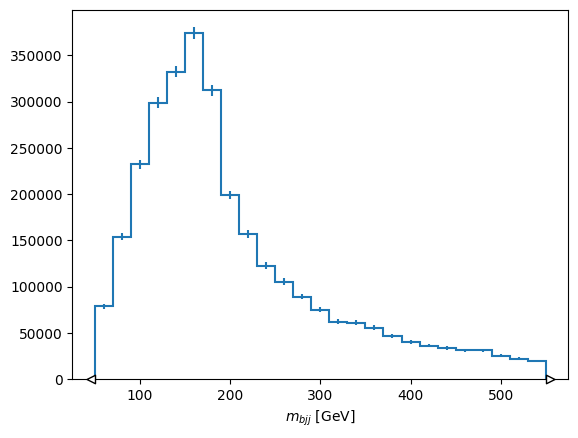

In [12]:
artists = out["hist_reco_mtop"][:, "ttbar", "nominal"].plot()

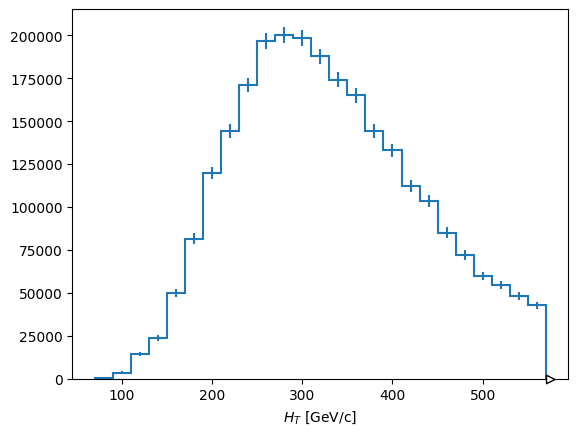

In [13]:
artists = out["hist_Ht"][:, "ttbar", "nominal"].plot()